# Entanglement entropy and Mutual Information analysis of Tmaze Active Inference Tensor Network




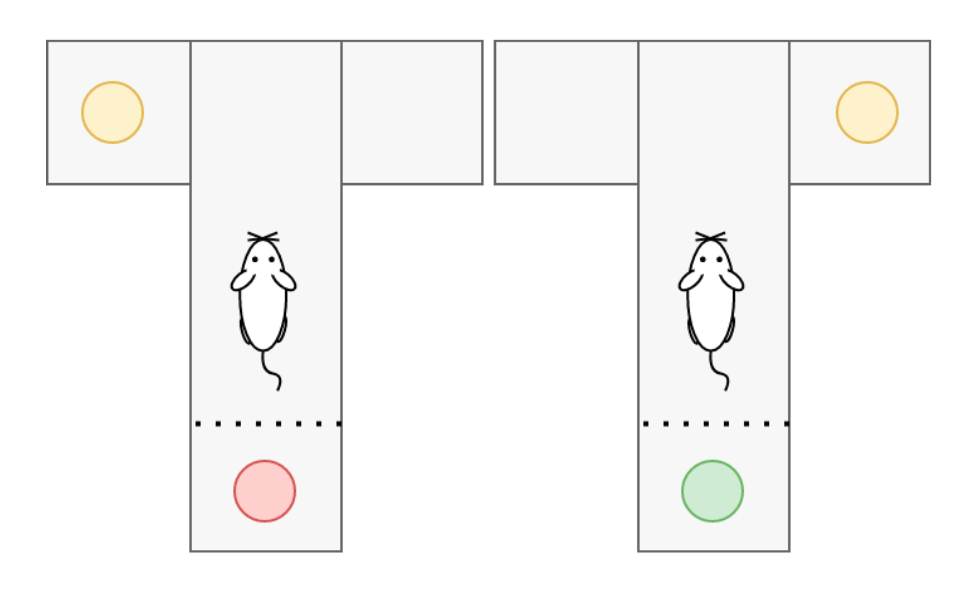







### A mouse has 24 possible observations given by its position [center, right, left, cue(down)] x reward [No reward, Win, Loss] x context [right, left]. The context determines in which position the reward is to be found. It is random, unless the mouse is in the cue position. The mouse has 4 actions [center, right, left, cue(down)]. The environment only runs for two time steps, so only two actions are performed


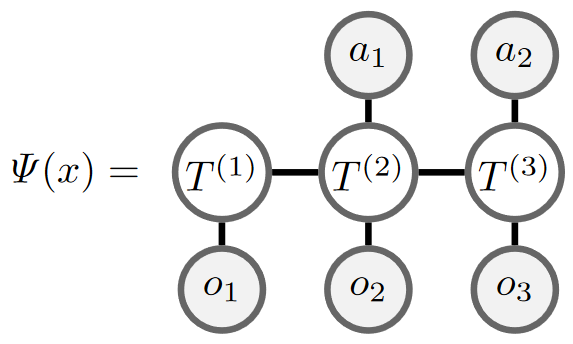

### A tensor network was trained to learn the generative model: P(o,a) of all possible actions and observations in the Tmaze environment. https://link.springer.com/content/pdf/10.1007%2F978-3-031-28719-0_20.pdf
### I will use the insights from https://arxiv.org/abs/2401.00867 to analyze the dependence (entanglement) between these variables. The objective is to show how Empowerment increases as information is gained.

In [1]:
%pip install -r requirements.txt

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'
Note: you may need to restart the kernel to use updated packages.


# Load data

In [2]:
import torch as t
import tensornetwork as tn
import numpy as np
import os
from src import Utils as u

# Specify the path to the .pt file
model = "SamuelModel.pt"

file_path = 'Saved_Models/' + model

# Load the .pt file
mps = t.load(file_path, weights_only=False)
T1,T2,T3 = mps.matrices

T1 = T1.numpy()
T2 = T2.numpy()
T3 = T3.numpy()
print(T1.shape, T2.shape, T3.shape)

(1, 4, 24, 2) (2, 4, 24, 4) (4, 4, 24, 1)


# Convert Wauthier Ansatz to MPS with explicit hidden states
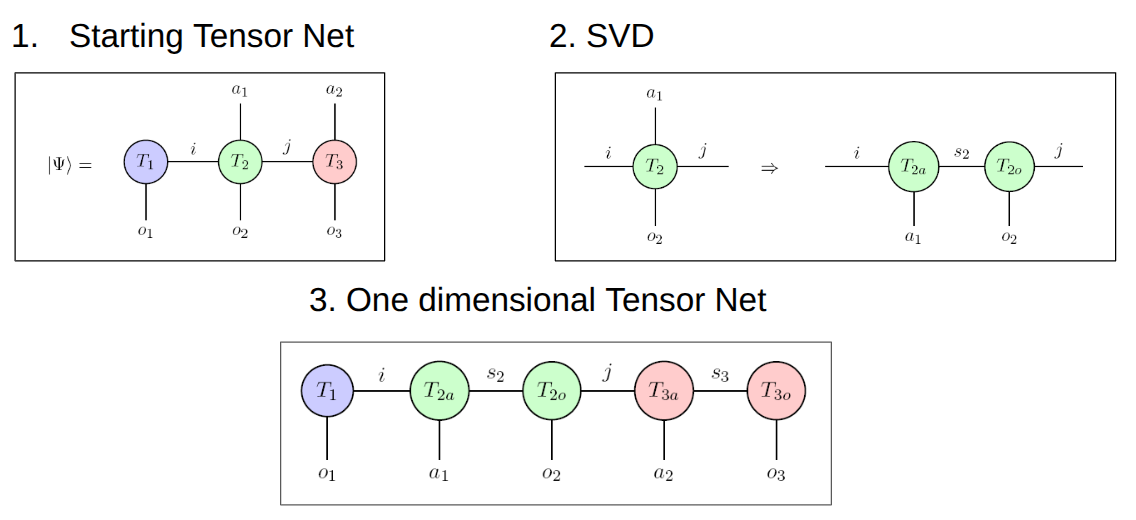

## Bring MPS into right gauge and add identity tensors to materialize hidden states

### T3

In [3]:


def svd_truncate(matrix, cutoff = 1e-2):

    U, S, Vh = np.linalg.svd(matrix, full_matrices=False)

    # Cutoff small singular values
    keep = min(len(S), np.sum(S > cutoff))

    U_trunc = U[:, :keep]
    S_trunc = S[:keep]
    Vh_trunc = Vh[:keep, :]

    return U_trunc, S_trunc, Vh_trunc, keep

U_trunc, S_trunc, Vh_trunc, s3 = svd_truncate(T3.reshape(16, 24))
# Pass singular values to the left
T3a = U_trunc @ np.diag(S_trunc)
T3a = T3a.reshape(4, 4, s3)

# Create 3rd-order identity tensor to extract hidden states
def delta(size):
    delta = np.zeros((size, size, size))
    for i in range(size):
        delta[i, i, i] = 1.0
    return delta

T3s = delta(s3)

# Keep unitary on the right so it becomes Identitiy when contracted with its conjugate transpose
T3o = Vh_trunc.reshape(s3, 24, 1)

print(T3a.shape, T3s.shape, T3o.shape)


(4, 4, 11) (11, 11, 11) (11, 24, 1)


### T2

In [4]:
T2_3 = tn.ncon([T2.reshape(8, 24,4), T3a], [[-1, -2, 1], [ 1, -3,  -4]])
U, S, Vh, j = svd_truncate(T2_3.reshape(8*24, 4*s3))

# Pass singular values to the left
T2ao = U @ np.diag(S)
T2ao = T2ao.reshape(8, 24, j)

T3a = Vh.reshape(j, 4, s3)

# Recover s2
U, S, Vh, s2 = svd_truncate(T2ao.reshape(8, 24*j))

# Pass singular values to the left
T2a = U @ np.diag(S)
T2a = T2a.reshape(2,4, s2)

T2s = delta(s2)

T2o = Vh.reshape(s2, 24, j)




### Remove irrelevant variables

In [5]:
# Fix inexistent action0 in T1
T1h = tn.ncon([T1[0], np.array([1, 0, 0, 0])], [[1, -1, -2], [1]])

# Fix initial observation
o1 = np.zeros((24)) # p = center, reward = None, Context = Right (irrelevant)
o1[0] = 1
T1h = tn.ncon([T1h, o1], [[1, -1], [1]])
T2h = tn.ncon([T1h, T2a], [[1], [1, -1, -2] ]).reshape(1, 4, s2)
T2h = T2h / np.sqrt(np.linalg.norm(T2h))



print("a1",T2h.shape, "s2",T2s.shape, "o2",T2o.shape, "a2",T3a.shape, "s3",T3s.shape, "o3",T3o.shape)
mps = [T2h, T2s, T2o, T3a, T3s, T3o]

a1 (1, 4, 8) s2 (8, 8, 8) o2 (8, 24, 4) a2 (4, 4, 11) s3 (11, 11, 11) o3 (11, 24, 1)


# Compute Reduced Density Matrix (RDM)
### An RDM is a description of a quantum subsystem, that contains information about iits entanglement to the rest of the total system. In our case, each variable is considered to be a subsystem. The RDM is obtained by summing over the other variables and ending up with a sort of Covariance matrix of our variables of interest. 

In [6]:
import tensornetwork as tn
def tensorNet(mps):

    # Convert MPS to TensorNetwork
    nodes = []
    conj_nodes = []
    for idx, tensor in enumerate(mps):
        nodes.append(tn.Node(tensor, name=f"node_{idx}"))
        conj_nodes.append(tn.Node(np.conj(tensor), name=f"conj_node_{idx}"))

    return nodes, conj_nodes

nodes, conj_nodes = tensorNet(mps)


 
 Initial sites: {0, 1}

 RDM tensor shape: (4, 8, 4, 8)


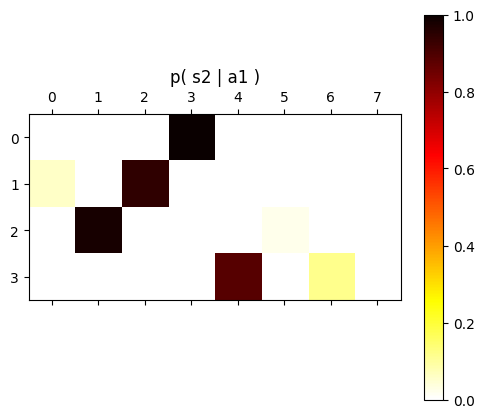

In [7]:
from scipy.stats import entropy
def von_neumann_entropy(rho, base=2):
    """Computes the von Neumann entropy of a density matrix."""
    # Filter out zero eigenvalues to avoid log(0)
    eigenvalues = np.linalg.eigvalsh(rho)
    non_zero_eigenvalues = eigenvalues[eigenvalues > 1e-12]
    return entropy(non_zero_eigenvalues, base=base)

def get_rdm(nodes, conj_nodes, sites):
    """
    Computes the reduced density matrix (RDM) for a given set of (ascending) sites.
    """

    print("\n \n Initial sites:", sites)

    # Due to left-canonicalization, we only need to contract up to the rightmost site.
    max_site = max(sites)
    nodes = nodes[:max_site + 1]
    conj_nodes = conj_nodes[:max_site + 1]
    #print("\n Nodes1:", nodes)

    # 1. Connect uninformative edges
    nodes[0][0] ^ conj_nodes[0][0]
    nodes[-1][2] ^ conj_nodes[-1][2]

    # 2. Connect the virtual "bond" indices of the MPS chain
    for i in range(max_site):
        nodes[i][2] ^ nodes[i+1][0]
        conj_nodes[i][2] ^ conj_nodes[i+1][0]

    # Define the open edges for the RDM
    open_edges = []
    for site_idx in sites:
        open_edges.append(nodes[site_idx][1])
    for site_idx in sites:
        open_edges.append(conj_nodes[site_idx][1])

    # Create a list of sites to be contracted (traced out)
    sites_to_contract = set(range(max_site + 1)) - sites

    # 3. Connect the physical indices of the sites to be traced out
    for i in sites_to_contract:
        nodes[i][1] ^ conj_nodes[i][1]

    # Contract the network to get the RDM tensor
    rdm_node = tn.contractors.auto(nodes + conj_nodes, output_edge_order=open_edges)
    rdm_tensor = rdm_node.tensor

    # Multiply the first half of the shape vector to get the matrix dimensions
    rdm_rows = int(np.prod(rdm_tensor.shape[:len(rdm_tensor.shape)//2]))
    print("\n RDM tensor shape:", rdm_tensor.shape)

    # Reshape into a matrix
    rdm = rdm_tensor.reshape(rdm_rows, rdm_rows)

    return rdm

rho_a1s2 = get_rdm(nodes, conj_nodes, {0,1})
rho_a1s2 = rho_a1s2 / np.trace(rho_a1s2)  # Normalize RDM

p_a1s2 = np.real(np.diag(rho_a1s2)).reshape(4, -1)
# Obtain conditional distribution p(s2|a1 ) by normalizing over s2 for each a1
p_s2_given_a1 = p_a1s2 / np.sum(p_a1s2, axis=1, keepdims=True)
u.plot_distribution(p_s2_given_a1, title="p( s2 | a1 )")


 
 Initial sites: {0, 2}

 RDM tensor shape: (4, 24, 4, 24)


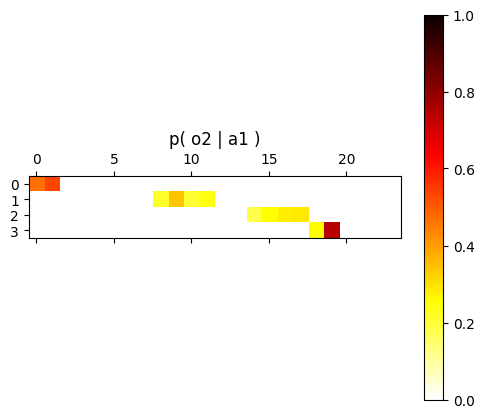

In [8]:
# Compute RDM for a1 and o2 (sites 0 and 2)
rho_a1o2 = get_rdm(nodes, conj_nodes, {0, 2})
rho_a1o2 = rho_a1o2 / np.trace(rho_a1o2)  # Normalize RDM

# Extract joint diagonal P(A1,O2) and conditional P(O2|A1)
p_a1o2 = np.real(np.diag(rho_a1o2)).reshape(4, -1)
p_o2_given_a1 = p_a1o2 / np.sum(p_a1o2, axis=1, keepdims=True)

u.plot_distribution(p_o2_given_a1, title="p( o2 | a1 )")


 
 Initial sites: {0, 2}

 RDM tensor shape: (4, 24, 4, 24)


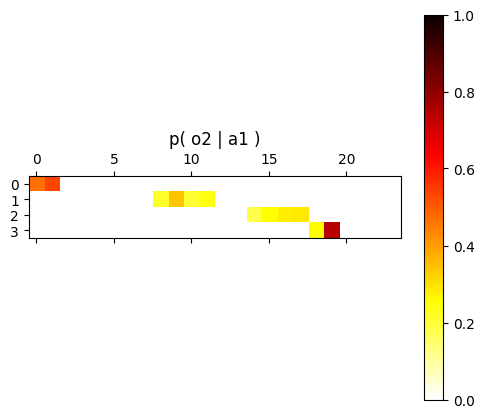

In [9]:
rho_a1s2 = get_rdm(nodes, conj_nodes, {0,2})
rho_a1s2 = rho_a1s2 / np.trace(rho_a1s2)  # Normalize RDM

p_a1s2 = np.real(np.diag(rho_a1s2)).reshape(4, -1)
# Obtain conditional distribution p(s2|a1 ) by normalizing over s2 for each a1
p_s2_given_a1 = p_a1s2 / np.sum(p_a1s2, axis=1, keepdims=True)
u.plot_distribution(p_s2_given_a1, title="p( o2 | a1 )")


 
 Initial sites: {3, 5}

 RDM tensor shape: (4, 24, 4, 24)


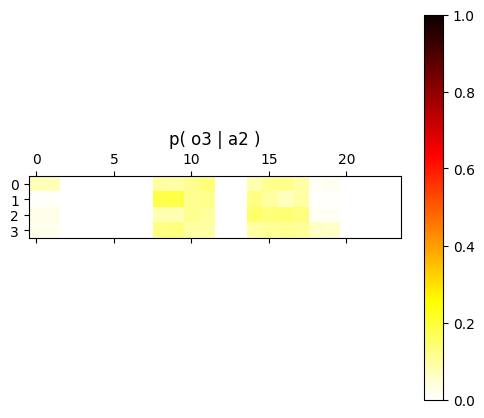

In [10]:
rho_a2o3 = get_rdm(nodes, conj_nodes, {3,5})
rho_a2o3 = rho_a2o3 / np.trace(rho_a2o3)  # Normalize RDM

p_a2o3 = np.real(np.diag(rho_a2o3)).reshape(4, -1)
# Obtain conditional distribution p(o3|a2 ) by normalizing over o3 for each a2
p_o3_given_a2 = p_a2o3 / np.sum(p_a2o3, axis=1, keepdims=True)
u.plot_distribution(p_o3_given_a2, title="p( o3 | a2 )")

In [11]:
def mutual_information(p_o_given_a, p_a, base=2):
    """
    Compute mutual information I(A;O) between actions and observations.
    
    Parameters:
    -----------
    p_o_given_a : numpy.ndarray, shape (n_actions, n_observations)
        Conditional probability matrix P(O|A)
    p_a : numpy.ndarray, shape (n_actions,)
        Marginal probability distribution P(A)
    base : float, default=2
        Base for logarithm (2 for bits, np.e for nats)
    
    Returns:
    --------
    mi : float
        Mutual information I(A;O) = H(A) - H(A|O)
    """
    
    # Check probabilities are normalized and non-negative
    assert np.allclose(np.sum(p_a), 1.0, atol=1e-12), f"p_a must sum to 1 (sum={np.sum(p_a)})"
    assert np.all(p_a >= -1e-12), "p_a must be non-negative"
    row_sums = np.sum(p_o_given_a, axis=1)
    assert np.allclose(row_sums, 1.0, atol=1e-12), f"Each row of p_o_given_a must sum to 1 (sums={row_sums})"
    assert np.all(p_o_given_a >= -1e-12), "p_o_given_a must be non-negative"
    
    # Compute joint distribution P(A,O) = P(O|A) * P(A)
    p_a = np.asarray(p_a).reshape(-1)
    assert p_o_given_a.shape[0] == p_a.shape[0], f"row mismatch: {p_o_given_a.shape[0]} vs {p_a.shape[0]}"
    p_joint = p_o_given_a * p_a[:, None]
    #u.plot_distribution(p_joint, title="Joint Distribution P(A,O)")
    # Compute marginal P(O) = sum_a P(A,O)
    p_o = np.sum(p_joint, axis=0)
    #u.plot_distribution(p_o[np.newaxis,:], title="Marginal Distribution P(O)")
    # Compute H(O) - entropy of observations

    h_o = entropy(p_o, base=base)
    
    # Compute H(O|A) - conditional entropy
    h_o_given_a = entropy(p_o_given_a, base=base, axis=1) 
    print("\n h_o_given_a:", h_o_given_a)
    print(" \n p(o|a) * p(a):", h_o_given_a * p_a)
    h_o_given_a = np.sum(h_o_given_a * p_a)
    print(" \n h_o_given_a (final):", h_o_given_a)

    # Mutual Information: I(A;O) = H(O) - H(O|A)
    mi = h_o - h_o_given_a
    print(" \n p(a):", p_a)
    print("\n mutual info:", mi)
    return mi /2

def empowerment_classical(p_o_given_a):
    """
    Compute classical empowerment as the maximum mutual information over all possible P(A).
    
    Parameters:
    -----------
    p_o_given_a : numpy.ndarray, shape (n_actions, n_observations)
        Conditional probability matrix P(O|A)
    base : float, default=2
        Base for logarithm
    
    Returns:
    --------
    max_mi : float
        Maximum mutual information (empowerment)
    optimal_p_a : numpy.ndarray
        Optimal action distribution that achieves maximum MI
    """
    
    n_actions = p_o_given_a.shape[0]
    
    # Try different action distributions to find maximum MI
    max_mi = 0.0
    optimal_p_a = None
    
    # Start with uniform distribution
    p_a_uniform = np.ones(n_actions) / n_actions
    mi_uniform = mutual_information(p_o_given_a, p_a_uniform)
    max_mi = mi_uniform
    optimal_p_a = p_a_uniform.copy()
    
    # Try some other distributions (this is a simplified search)
    # For optimal solution, you'd need to solve the optimization problem
    from scipy.optimize import minimize
    
    def negative_mi(p_a_flat):
        # Ensure probabilities sum to 1 and are non-negative
        p_a = np.abs(p_a_flat)
        p_a = p_a / np.sum(p_a)
        return -mutual_information(p_o_given_a, p_a)
    
    # Use Blahut-Arimoto to find capacity (max MI) and optimal p_a
    P = np.array(p_o_given_a, dtype=float)  # shape (n_actions, n_observations)
    eps = 1e-12
    max_iters = 10000
    tol = 1e-9

    # initialize uniform
    p = np.ones(n_actions) / n_actions
    for _ in range(max_iters):
        q = p @ P  # P(o) = sum_a p(a) P(o|a)
        q = np.clip(q, eps, None)

        # compute D(a) = sum_o P(o|a) * log2( P(o|a) / q(o) )
        P_clipped = np.clip(P, eps, None)
        D = np.sum(P_clipped * (np.log2(P_clipped) - np.log2(q)), axis=1)

        # update p(a) proportional to 2^{D(a)}
        p_new = 2 ** D
        p_new /= np.sum(p_new)

        if np.linalg.norm(p_new - p, 1) < tol:
            p = p_new
            break
        p = p_new

    optimal_p_a = p
    max_mi = float(np.sum(optimal_p_a * D))

    # create minimal result object to keep downstream compatibility
    class _Res: pass
    result = _Res()
    result.success = True
    result.x = optimal_p_a
    
    if result.success:
        optimal_p_a = np.abs(result.x)
        optimal_p_a = optimal_p_a / np.sum(optimal_p_a)
        max_mi = mutual_information(p_o_given_a, optimal_p_a)

    return max_mi, optimal_p_a



In [12]:
# Compute RDM and empowerment for A1 and O2

# Dimensions from existing arrays
dim_a1 = p_a1o2.shape[0]
dim_o2 = p_a1o2.shape[1]

# Trace out O2 from rho_a1o2 to get rho_a1
rho_a1 = rho_a1o2.reshape(dim_a1, dim_o2, dim_a1, dim_o2)
rho_a1 = np.trace(rho_a1, axis1=1, axis2=3)

# Extract marginal P(A1)
p_a1 = np.sum(p_a1o2, axis=1)

# Compute mutual information I(A1;O2)
mi_a1_o2 = mutual_information(p_o2_given_a1, p_a1)
print(f"Mutual Information of environment I(A1;O2) = {mi_a1_o2:.6f} bits")

# Compute classical empowerment (max MI) and optimal P(A1)
empowerment_a1_o2, optimal_p_a1 = empowerment_classical(p_o2_given_a1)
print(f"Empowerment (max MI) = {empowerment_a1_o2:.6f} bits")
print(f"Optimal P(A1) = {optimal_p_a1}")



 h_o_given_a: [0.99689956 1.96798867 1.97881066 0.82771243]
 
 p(o|a) * p(a): [0.23565987 0.61843914 0.61803049 0.11342446]
 
 h_o_given_a (final): 1.5855539560661898
 
 p(a): [0.23639279 0.31424934 0.31232422 0.13703365]

 mutual info: 1.9339605136936404
Mutual Information of environment I(A1;O2) = 0.966980 bits

 h_o_given_a: [0.99689956 1.96798867 1.97881066 0.82771243]
 
 p(o|a) * p(a): [0.24922489 0.49199717 0.49470266 0.20692811]
 
 h_o_given_a (final): 1.4428528270860062
 
 p(a): [0.25 0.25 0.25 0.25]

 mutual info: 1.9999999047994308

 h_o_given_a: [0.99689956 1.96798867 1.97881066 0.82771243]
 
 p(o|a) * p(a): [0.24922489 0.49199717 0.49470266 0.20692811]
 
 h_o_given_a (final): 1.4428528270860062
 
 p(a): [0.25 0.25 0.25 0.25]

 mutual info: 1.9999999047994308
Empowerment (max MI) = 1.000000 bits
Optimal P(A1) = [0.25 0.25 0.25 0.25]


In [13]:
# Example usage with your existing data:
# Extract P(O|A) from your RDM


# Trace out O3 from rho_a2o3 to get rho_a2, then compute its eigenvalues
dim_a2 = p_a2o3.shape[0]
dim_o3 = p_a2o3.shape[1]

rho_a2 = rho_a2o3.reshape(dim_a2, dim_o3, dim_a2, dim_o3)
rho_a2 = np.trace(rho_a2, axis1=1, axis2=3)

# Enforce Hermiticity to avoid tiny numerical imag parts
rho_a2 = (rho_a2 + rho_a2.conj().T) / 2

eigvals = np.linalg.eigvalsh(rho_a2)
eigvals = np.real(eigvals)


# Extract marginal P(A2)
p_a2 = np.sum(p_a2o3, axis=1, keepdims=True)

# Compute mutual information
mi_a2_o3 = mutual_information(p_o3_given_a2, p_a2)
print(mi_a2_o3)
print(f"Mutual Information I(A2;O3) = {mi_a2_o3:.4f} bits")

# Compute empowerment (maximum MI)
empowerment_a2_o3, optimal_p_a2 = empowerment_classical(p_o3_given_a2)
print(f"Empowerment (max MI) = {empowerment_a2_o3:.4f} bits")
print(f"Optimal P(A2) = {optimal_p_a2}")


 h_o_given_a: [3.41833364 3.08437056 3.27844614 3.43626964]
 
 p(o|a) * p(a): [0.80336072 0.84371853 0.90316242 0.74207401]
 
 h_o_given_a (final): 3.292315683159625
 
 p(a): [0.2350153  0.27354642 0.2754849  0.21595337]

 mutual info: 0.08394712166057294
0.04197356083028647
Mutual Information I(A2;O3) = 0.0420 bits

 h_o_given_a: [3.41833364 3.08437056 3.27844614 3.43626964]
 
 p(o|a) * p(a): [0.85458341 0.77109264 0.81961154 0.85906741]
 
 h_o_given_a (final): 3.3043549979435722
 
 p(a): [0.25 0.25 0.25 0.25]

 mutual info: 0.0833563699037323

 h_o_given_a: [3.41833364 3.08437056 3.27844614 3.43626964]
 
 p(o|a) * p(a): [0.85857086 0.79174548 0.8049734  0.84739271]
 
 h_o_given_a (final): 3.3026824476266614
 
 p(a): [0.25116649 0.25669597 0.24553504 0.24660251]

 mutual info: 0.08381090829331317
Empowerment (max MI) = 0.0419 bits
Optimal P(A2) = [0.25116649 0.25669597 0.24553504 0.24660251]


# Remaining tasks


## Main objective is to extract Empowerment and Infogain for a Tmaze agent with traps and without. We wish to show that Empowerment increases when taking action that gains info

### 1. Compute Empowerment between a1 and o2
- One formula is the Quantum Mutual Information between these variables.
- For the classical formula we just need to extract $p( o | a ) $ and then compute the mutual information by taking the maximum over several choices of $p( a ) $ as the MI is the Shannon Entropy of $p(o) = \sum_a P(o|a)p(a)$ minus Entropy of $p( o | a) $

### 2. Compute infogain of a1
- Quantum Mutual information between s1 and o2 when a1 is fixed to each possibility
- Classical MI between s1 and o2 whehn a1 is fixed computed as $H[p(s)] - H[p(s|o)]$

### 3. Compute Empowerment between a2 and o3 when a1 is fixed
- Same as above except one has to fix a1 = Cue
- Same as above except one has to fix a1 = Center
- Same as above except one has to fix a1 = Right


